In [1]:
import deepSI
import numpy as np

class DuffingOscillator(deepSI.System_deriv):
    def __init__(self):
        super(DuffingOscillator, self).__init__(nx=2, dt=0.1)
        self.alpha = 1
        self.beta = 5
        self.gamma = 1
        self.delta = 0.02
        self.omega = 0.5

    def deriv(self,x,u):
        z1,z2 = x
        dz1 = self.gamma*u - self.delta*z1 - self.alpha*z2 - self.beta*(z2**3)
        dz2 = z1
        return [dz1,dz2]

    def h(self,x,u):
        return x[1]

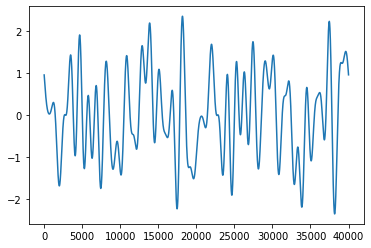

In [2]:
from matplotlib import pyplot as plt
u = deepSI.deepSI.exp_design.multisine(40000, pmax=41)
plt.plot(u)

In [3]:

# from matplotlib import pyplot as plt
# dt = np.arange(10000)*0.1
# u = np.cos(0.5*dt)

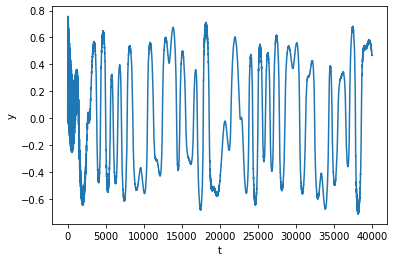

In [4]:
sys = DuffingOscillator()
data = sys.apply_experiment(deepSI.System_data(u=u))
data.plot()

In [5]:
ss_enc = deepSI.fit_systems.SS_encoder(nx=2, na=2, nb=2, feedthrough=False)
train, test = data.train_test_split(split_fraction=0.2)
train, val  = train.train_test_split(split_fraction=0.25)

ss_enc.fit(train_sys_data=train, val_sys_data=val, epochs=20, batch_size=256, loss_kwargs={'nf':150})

Initilizing the model and optimizer
Size of the training array =  55.3 MB
N_training_samples = 23849, batch_size = 256, N_batch_updates_per_epoch = 93
Initial Validation sim-NRMS= 1.2946598150115778


  0%|          | 0/20 [00:00<?, ?it/s]

########## New lowest validation loss achieved ########### sim-NRMS = 0.07058377873707586
Epoch    1, sqrt loss  0.4265, Val sim-NRMS 0.07058, Time Loss: 93.0%, data: 0.2%, val: 6.9%,  4.0 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.04703117603009445
Epoch    2, sqrt loss  0.1218, Val sim-NRMS 0.04703, Time Loss: 92.8%, data: 0.2%, val: 7.0%,  4.1 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.03160308845416849
Epoch    3, sqrt loss  0.1158, Val sim-NRMS 0.0316, Time Loss: 92.9%, data: 0.2%, val: 6.9%,  4.0 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.02314095513840514
Epoch    4, sqrt loss  0.1137, Val sim-NRMS 0.02314, Time Loss: 92.9%, data: 0.2%, val: 7.0%,  3.9 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.020695471212924955
Epoch    5, sqrt loss  0.1124, Val sim-NRMS 0.0207, Time Loss: 92.9%, data: 0.2%, val: 7.0%,  3.9 batches/

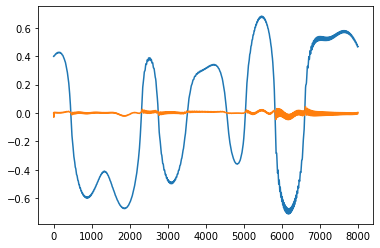

In [6]:
test_ss_enc = ss_enc.apply_experiment(test)

plt.plot(test.y)
plt.plot(test.y - test_ss_enc.y)

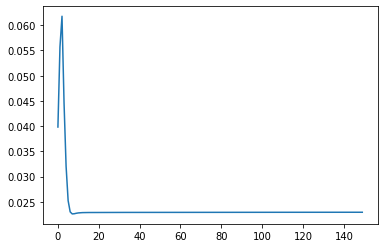

In [7]:
nsteperror = ss_enc.n_step_error(test,nf=150) #return in NRMS units of fit_sys_ss_enc.norm
plt.plot(nsteperror)

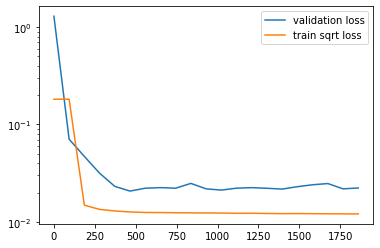

In [8]:
ss_enc.checkpoint_load_system('_last')
plt.semilogy(ss_enc.batch_id,ss_enc.Loss_val,label='validation loss')
plt.semilogy(ss_enc.batch_id,ss_enc.Loss_train,label='train sqrt loss')
plt.legend()

In [9]:
ss_enc.fn

simple_res_net(
  (net_lin): Linear(in_features=3, out_features=2, bias=True)
  (net_non_lin): feed_forward_nn(
    (net): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
      (4): Linear(in_features=64, out_features=2, bias=True)
    )
  )
)

In [10]:
params = {}
for name, param in ss_enc.fn.named_parameters():
    params[name] = param.detach().numpy()

In [11]:
params.keys()

dict_keys(['net_lin.weight', 'net_lin.bias', 'net_non_lin.net.0.weight', 'net_non_lin.net.0.bias', 'net_non_lin.net.2.weight', 'net_non_lin.net.2.bias', 'net_non_lin.net.4.weight', 'net_non_lin.net.4.bias'])

In [12]:
from casadi import *
Wlin = np.matrix(params["net_lin.weight"])
blin = np.matrix(params["net_lin.bias"]).T
W0 = np.matrix(params["net_non_lin.net.0.weight"])
b0 = np.matrix(params["net_non_lin.net.0.bias"]).T
W2 = np.matrix(params["net_non_lin.net.2.weight"])
b2 = np.matrix(params["net_non_lin.net.2.bias"]).T
W4 = np.matrix(params["net_non_lin.net.4.weight"])
b4 = np.matrix(params["net_non_lin.net.4.bias"]).T
blin.shape

(2, 1)

In [13]:
x = np.matrix('0;0;0')
(mtimes(W4, tanh(mtimes(W2, tanh(mtimes(W0,x)+b0))+b2))+b4 + mtimes(Wlin,x) + blin).elements()

[-0.1801172464617783, -0.41766105871984477]

In [14]:
x = MX.sym("x",2,1)
u = MX.sym("u",1,1)
xu = vertcat(x,u)
nn = mtimes(W4, tanh(mtimes(W2, tanh(mtimes(W0,xu)+b0))+b2))+b4 + mtimes(Wlin,xu) + blin
f = Function('f', [x, u], [nn])
f([0,0],0).elements()

[-0.1801172464617783, -0.41766105871984477]

In [15]:
import torch
xt = torch.tensor([0,0,0], dtype=torch.float)
net = ss_enc.fn
net(xt).detach().numpy()

array([-0.18011725, -0.41766107], dtype=float32)

In [16]:
Jfx = Function("Jfx", [x, u], [jacobian(nn,x)])
Jfu = Function("Jfu", [x, u], [jacobian(nn,u)])

In [27]:
Jfx([0,0],0)#.elements()

DM(
[[0.777439, -0.566541], 
 [-0.231987, -0.619298]])

In [24]:
Jfu([0,0],0)

DM([1.06714, 1.75541])

In [75]:
from torch.autograd import functional as F
xt = torch.tensor([0,0,0], dtype=torch.float)
F.jacobian(ss_enc.fn, xt)

tensor([[ 0.7774, -0.5665,  1.0671],
        [-0.2320, -0.6193,  1.7554]])